# developing birth death rate measurement from the classical process
Tim Tyree<br>
7.11.2025

In [1]:
from lib.my_initialization import *

plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# define module

In [2]:
#TODO: move these to lib
#set initial number of particles
@njit
def comp_first_passage_time_paired_bd_process(
        N=6,
        DT=0.1,
        random_state=42,
        max_num_steps=1000000,**kwargs):
    """
    Example Usage:
first_passage_time = comp_first_passage_time_paired_bd_process(N=6,
            random_state=42,max_num_steps=1000000)#,**kwargs)
    """
    np.random.seed(random_state)
    error_code=0
    assert N%2==0
    step=0
    dont_break=True
    while dont_break:
        #compute transition probabilities
        pup = Wp(N)*DT
        pum = Wm(N)*DT
        #randomly sample a value
        p = np.random.rand()
        #change depending on that value
        if p>pup:
            N+=2
        if p<pum:
            N-=2
        #i know edge case exists for ~1/2 of the sample in theory.
        #decide edge cases by predominance
        #by setting switch to go up instead of down when transition is otherwise undefined.
        #else, we'll keep to the default, wherein negative wins...
        if pum>pup:
            #closest one to half wins
            dpum=np.abs(0.5-pum)
            dpup=np.abs(0.5-pup)
            if dpup<dpum:
                #then for once, positive wins!
                if (p>pup) & (p<pum):
                    N+=2
        #break if not a particle exists
        if N<1:
            dont_break=False
        elif step>max_num_steps:
            dont_break=False
            error_code=1
        step+=1

    first_passage_time = step*DT
    return first_passage_time

def construct_transition_matrix_paired_bd_process(Wp,Wm,
                                max_num_particles_init_over_2=200,**kwargs):
    """
    Example Usage:
DT=0.000025 #stable?
t_matrix = construct_transition_matrix_paired_bd_process(Wp,Wm,
                                max_num_particles_init_over_2=200)#,**kwargs)
t_matrix*=DT #transfer func is now in dimensionless units 
    """
    dim=max_num_particles_init_over_2
    #precompute the transition matrix
    N_values = 2*(1+np.arange(dim))
    t_matrix=np.zeros((dim,dim))
    for i,N in enumerate(N_values):
        flux_in_lo = Wp(N-2)
        flux_in_hi = Wm(N+2)
        flux_out= Wp(N) + Wm(N)
        t_matrix[i,i]-=flux_out
        t_matrix[i,i-1]+=flux_in_lo
        if i+1<dim:
            t_matrix[i,i+1]+=flux_in_hi
    t_matrix[0,0] = -(Wm(2)+Wp(2)) # from N=2
    t_matrix[0,1] = Wm(4) # from N=4
    #reflecting bc at end
    Nmax=int(N_values[-1])
    t_matrix[-1,-1] = -Wm(Nmax) #-(Wm(Nmax)+Wp(Nmax)) 
    t_matrix[-1,-2] = Wp(Nmax-2) 
    return t_matrix

def integrate_transition_matrix(t_matrix,P_values,
                                num_steps=100000,
                                save_every=1000,**kwargs):
    """
    Example Usage:
P_values=P_qs.copy()
print(f"{sum(P_values)=}")
t_values,P_net_values = integrate_transition_matrix(t_matrix,P_values,
                                num_steps=100000,save_every=1000)#,**kwargs)
print(f"{P_net_values[-1]=}")
    """
    #input:  
    #output: 
    P_net_lst=[]
    step_lst=[]
    for step in range(num_steps):
        # dP_values=np.dot(t_matrix,P_values)
        P_values+=np.dot(t_matrix,P_values)#dP_values
        if step%save_every==0:
            P_net = np.sum(P_values)
            #record
            P_net_lst.append(P_net)
            step_lst.append(step)
        #P_net_values[step]=P_net
    P_net_values=np.array(P_net_lst)
    t_values=np.array(step_lst)*DT #seconds
    return t_values,P_net_values


# t_values=np.arange(num_steps)*DT #seconds

# precompute jump threshold transition matrix

In [3]:
wjr=recall_powerlaw_fits_to_full_models()

# input_fn = search_for_file()
# input_fn

kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')

# birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
birth_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; MPE=3.0209%; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; MPE=4.2323%; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [4]:
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'

In [5]:
#TODO: compute the eigenvalues of the transition matrix
#TODO: compute the fraction terminated time trace initializing at the quasistatic distribution
#estimate the quasistatic distribution
L=5 #cm
A=L**2
# A = 100
num_iter=20

#TODO: recall the powerlaw fits to the FK model 
#heretim

# Wp = get_comp_W(A,nup,Mp)
# Wm = get_comp_W(A,num,Mm)
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
Wp = njit(comp_Wp)
Wm = njit(comp_Wm)

# n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(Wm,Wp,num_iter=num_iter,freq_prev=100.)
n_qs,prob_qs

(array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
        36, 38, 40]),
 array([5.42628538e-02, 1.61763258e-01, 2.46906253e-01, 2.38316933e-01,
        1.61554457e-01, 8.24016974e-02, 3.34722324e-02, 1.15971026e-02,
        3.88516866e-03, 1.56938889e-03, 8.95912708e-04, 6.56916952e-04,
        5.33683012e-04, 4.50294894e-04, 3.87184786e-04, 3.37305051e-04,
        2.96949507e-04, 2.63740779e-04, 2.36031349e-04, 2.12635957e-04]))

# discrete simulation of multiple particle number timeseries

In [25]:
#precompute jump likelihoods
# DT = 1e-5
# DT = 1e-3
# DT = 1e-8
# DT = 1e-6
DT = 1e-7

max_num_particles_init_over_2=200
Jp_values = np.array([DT*Wp(n) for n in range(2*max_num_particles_init_over_2)]) #N-->N+2
Jm_values = np.array([DT*Wm(n) for n in range(2*max_num_particles_init_over_2)]) #N-->N-2
size = Jp_values.shape[0]
jump_likelihood_matrix = np.eye(size)
for i in range(size):
    jump_likelihood_matrix[i,i-2] = Jm_values[i-2]
    if i+2<size:
        jump_likelihood_matrix[i,i+2] = Jp_values[i+2]
        jump_likelihood_matrix[i,i] -= jump_likelihood_matrix[i,i-2] + jump_likelihood_matrix[i,i+2]
    else:
        #implement reflecting b.c.'s at the maximum
        jump_likelihood_matrix[i,i] -= jump_likelihood_matrix[i,i-2]
# jump_likelihood_matrix = jump_likelihood_matrix.T

In [26]:
#fix start of transition matrix
# sum(jump_likelihood_matrix[1])
jump_likelihood_matrix[1,-1] = 0
jump_likelihood_matrix[1,1] = 1 - jump_likelihood_matrix[1,3]
jump_likelihood_matrix[2,0] = Wm(2)*DT
jump_likelihood_matrix[2,2] = 1 - jump_likelihood_matrix[2,4] - jump_likelihood_matrix[2,0]
# set absorbing b.c.'s
jump_likelihood_matrix[0] *= 0.
jump_likelihood_matrix[0,0] = 1.

In [27]:
# np.rollaxis(jump_likelihood_matrix,0,2)
# np.roll(jump_likelihood_matrix,2,axis=0)
matrix = jump_likelihood_matrix
# Get the main diagonal
main_diagonal = np.diag(matrix)
# print("Main Diagonal:", main_diagonal) # Output: [1 5 9]

# Get the diagonal above the main diagonal (k=1)
upper_diagonal = np.diag(matrix, k=2)
# print("Upper Diagonal:", upper_diagonal) # Output: [2 6]

# Get the diagonal below the main diagonal (k=-1)
lower_diagonal = np.diag(matrix, k=-2)
# print("Lower Diagonal:", lower_diagonal) # Output: [4 8]
# np.roll?

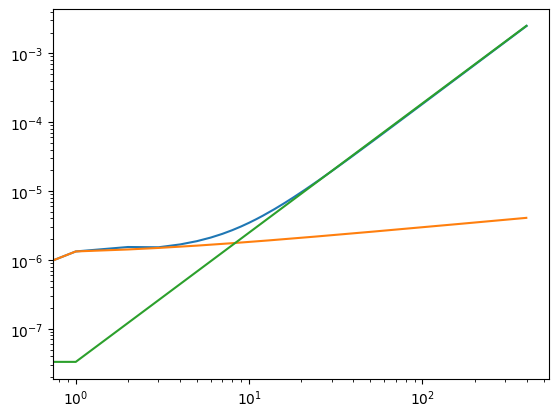

In [28]:
plt.plot(1-main_diagonal)
plt.plot(upper_diagonal)
plt.plot(lower_diagonal)
# plt.xlim([1,250])
# plt.ylim([1e-6,1e-2])
plt.xscale('log')
plt.yscale('log')

In [29]:
# sum(jump_likelihood_matrix[2])
jump_threshold_matrix = np.cumsum(jump_likelihood_matrix,axis=1)

In [30]:
# print(np.around(jump_likelihood_matrix,6)[0,:5])
# print(np.around(jump_likelihood_matrix,6)[:5,0])

In [31]:
# print('start:')
# print(np.around(jump_likelihood_matrix,6)[:5,:5])
# print('end:')
# print(np.around(jump_likelihood_matrix,6)[-5:,-5:])

# run multiple particle simulations in parallel, computing transition durations, as before, from number time series

In [32]:
# print(jump_threshold_matrix[:6,:6])

In [33]:
@njit
def simulate_jump_process_transition_rates(jump_threshold_matrix,
        tmax = 1.,
        num_simulations = 20, #linear run time in this kwarg
        N0 = 2,
        DT = 1e-5, #s
        seed = 42):
    """Aggregates all birth/death (increasing/decreasing index) jump reactions into the same output array.
    
    Example Usage:
num_terminated,Np_values,Nm_values,Wp_values,Wm_values,nobsp_values,nobsm_values = simulate_jump_process_transition_rates(jump_threshold_matrix,
        tmax = 1.,
        num_simulations = 20, #linear run time in this kwarg
        N0 = 2,
        DT = 1e-5, #s
        seed = 42)
    """
    N_values = np.zeros(int(num_simulations),dtype='int') + int(N0)
    step_values = np.zeros(int(num_simulations),dtype='int') #step of last transition
    np.random.seed(seed)
    Nmax = jump_threshold_matrix.shape[0]
    #initialize counter arrays
    T_ip = np.zeros(Nmax,dtype='int')
    T_im = np.zeros(Nmax,dtype='int')
    M_ip = np.zeros(Nmax,dtype='int')
    M_im = np.zeros(Nmax,dtype='int')
    max_num_steps = int(tmax/DT)
    for step in range(max_num_steps):
        t = DT*step
        #make it only run where N_values>0 for efficiency
        still_running = N_values>0
        num_terminated = np.sum(~still_running)
        P_values = np.random.rand(num_simulations - num_terminated)
        boo = P_values<jump_threshold_matrix[N_values[still_running]].T
        indices = np.argwhere(still_running)
        for i in range(num_simulations - num_terminated):
            Nnext = np.argwhere(boo[:,i])[0,0]
            ix = indices[i,0]
            Nold  = N_values[ix]
            #record any change of step
            if Nnext != Nold:
                last_transition_step = step_values[ix]
                #record birth or death transition
                if last_transition_step>0:
                    count = step - last_transition_step
                    assert count > 0 
                    if Nnext > Nold:
                        #count birth transition
                        M_ip[Nold] +=1
                        T_ip[Nold] +=count
                    else:
                        #count death transition
                        M_im[Nold] +=1
                        T_im[Nold] +=count
                #record new state
                N_values[ix] = Nnext
                step_values[ix] = step
    return num_terminated,T_ip,T_im,M_ip,M_im
#     #compute rates
#     boop = T_ip>0
#     boom = T_im>0
#     Wp_values = M_ip[boop]/T_ip[boop]/DT #Hz
#     Wm_values = M_im[boom]/T_im[boom]/DT #Hz
#     #compute sample sizes
#     nobsp_values = M_ip[boop]
#     nobsm_values = M_im[boom]
#     #compute the abcissa
#     Np_values = np.argwhere(boop).flatten()
#     Nm_values = np.argwhere(boom).flatten()
#     return num_terminated,Np_values,Nm_values,Wp_values,Wm_values,nobsp_values,nobsm_values

In [34]:
# taking more than an hour at DT=1e-8... 
# num_terminated,Np_values,Nm_values,Wp_values,Wm_values,nobsp_values,nobsm_values = simulate_jump_process_transition_rates(jump_threshold_matrix,
num_terminated,T_ip,T_im,M_ip,M_im = simulate_jump_process_transition_rates(jump_threshold_matrix,
#         tmax = 1.,
        tmax = 100.*DT,
#         num_simulations = 200, #linear run time in this kwarg
        num_simulations = 2, #linear run time in this kwarg
        N0 = 2,
        DT = DT, #s
#         DT = 1e-5, #s
#         DT = 1e-3, #s
        seed = 42)

In [35]:
#TODO: patiently verify whether DT=1e-8 needs to be a thing
#TODO: parallelize simulate_jump_process_transition_rates over many cores
def routine(task):
    jump_threshold_matrix,tmax,num_simulations,N0,DT,seed = task
#     num_terminated,T_ip,T_im,M_ip,M_im = simulate_jump_process_transition_rates(jump_threshold_matrix,
    return simulate_jump_process_transition_rates(jump_threshold_matrix,
                tmax = tmax, #s
                num_simulations = num_simulations, #linear run time in this kwarg
                N0 = N0,
                DT = DT, #s
                seed = seed)

In [54]:
ncores = 14
tmax = 1. #s
# tmax = .1 #s
# num_simulations = int(200/ncores)
num_simulations = int(500/ncores)
# N0 = 2
N0 = 20
#heretim
# DT = 1e-6
task_lst = []
for seed in range(ncores):
    task = jump_threshold_matrix,tmax,num_simulations,N0,DT,seed
    task_lst.append(task)

In [55]:
#Q: did i call eval_... right?
#A: yup.
# eval_routine_multiprocess?

In [56]:
%%time
retval_lst = eval_routine_multiprocess(routine,task_lst,ncores)

CPU times: user 31 ms, sys: 147 ms, total: 178 ms
Wall time: 5min 38s


In [96]:
num_terminated,T_p,T_m,M_p,M_m = retval_lst[0]
for retval in retval_lst[1:]:
    num_terminated,T_ip,T_im,M_ip,M_im = retval
    #accumulate the answers
    T_p+=T_ip
    T_m+=T_im
    M_p+=M_ip
    M_m+=M_im

In [113]:
# #compute rates
# boop = T_ip>0
# boom = T_im>0
# Wp_values = M_ip[boop]/T_ip[boop]/DT #Hz
# Wm_values = M_im[boom]/T_im[boom]/DT #Hz
# #compute sample sizes
# nobsp_values = M_ip[boop]
# nobsm_values = M_im[boom]
# #compute the abcissa
# Np_values = np.argwhere(boop).flatten()
# Nm_values = np.argwhere(boom).flatten()

In [114]:
#compute rates
boop = T_p>0
boom = T_m>0
boob = boop * boom
Wp_values = M_p[boob]/T_p[boob]/DT #Hz
Wm_values = M_m[boob]/T_m[boob]/DT #Hz
Wp_values*= M_p[boob] / (M_p[boob] + M_m[boob])
Wm_values*= M_m[boob] / (M_p[boob] + M_m[boob])
#compute sample sizes
# nobsp_values = M_p[boop]
# nobsm_values = M_m[boom]
nobsp_values = M_p[boob]
nobsm_values = M_m[boob]
#compute the abcissa
# Np_values = np.argwhere(boop).flatten()
# Nm_values = np.argwhere(boom).flatten()
Np_values = np.argwhere(boob).flatten()
Nm_values = np.argwhere(boob).flatten()

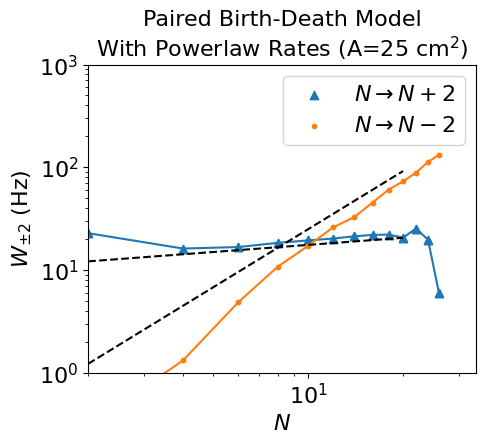

In [115]:
# nobsp_values
# nobsm_values
# Np_values
# Nm_values
fontsize = 16
#plot 1-diagonal of the transition matrix
Wsumv=(1-np.diag(jump_likelihood_matrix))/DT #Hz
Nv=np.arange(Wsumv.shape[0])

fig,ax=plt.subplots(figsize=(5,4))
# plt.plot(Nv,Wsumv,'r--',label='$W_{+2}(N)+W_{-2}(N)$')
#plot the simulation results
plt.plot(Np_values,Wp_values,color='C0',marker='^')#,label=r'$N\rightarrow N+2$')
plt.plot(Nm_values,Wm_values,color='C1',marker='.')#,label=r'$N\rightarrow N-2$')
plt.scatter(Np_values,Wp_values,color='C0',marker='^',label=r'$N\rightarrow N+2$')
plt.scatter(Nm_values,Wm_values,color='C1',marker='.',label=r'$N\rightarrow N-2$')
plt.legend(fontsize=fontsize)
format_plot(fontsize=fontsize,xlabel=r'$N$',ylabel=r'$W_{\pm2}$ (Hz)')
plt.xscale('log')
plt.yscale('log')

xv = np.linspace(2,20,101)
plt.plot(xv,Mp*A*(xv/A)**nup,'k--')
plt.plot(xv,Mm*A*(xv/A)**num,'k--')

plt.xlim([2,34])
plt.ylim([1,1e3])

plt.title(f'Paired Birth-Death Model\nWith Powerlaw Rates ({A=} cm'+r'$^2$)',fontsize=fontsize)

plt.show()

In [112]:
# # nobsp_values
# # nobsm_values
# # Np_values
# # Nm_values
# fontsize = 16
# #plot 1-diagonal of the transition matrix
# Wdiffv=(
#     np.diag(jump_likelihood_matrix,k=2) - np.diag(jump_likelihood_matrix,k=-2)
#     )/DT #Hz
# Nv=np.arange(Wdiffv.shape[0])

# fig,ax=plt.subplots(figsize=(5,4))
# plt.plot(Nv,Wdiffv,'r--',label='$W_{+2}(N)-W_{-2}(N)$')
# #plot the simulation results
# plt.plot(Np_values,Wp_values-Wm_values[:-1],color='C0',marker='^')#,label=r'$N\rightarrow N+2$')
# # plt.plot(Nm_values,Wm_values,color='C1',marker='.')#,label=r'$N\rightarrow N-2$')
# # plt.scatter(Np_values,Wp_values,color='C0',marker='^',label=r'$N\rightarrow N+2$')
# # plt.scatter(Nm_values,Wm_values,color='C1',marker='.',label=r'$N\rightarrow N-2$')
# plt.legend(fontsize=fontsize)
# format_plot(fontsize=fontsize,xlabel=r'$N$',ylabel=r'$W_{\pm2}$ (Hz)')
# # plt.xscale('log')
# # plt.yscale('log')

# # xv = np.linspace(2,20,101)
# # plt.plot(xv,Mp*A*(xv/A)**nup,'k--')
# # plt.plot(xv,Mm*A*(xv/A)**num,'k--')

# plt.xlim([2,34])
# plt.ylim([0,0.3])

# plt.title(f'Paired Birth-Death Model\nWith Powerlaw Rates ({A=} cm'+r'$^2$)',fontsize=fontsize)

# plt.show()

In [108]:
#compute rates
boop = T_p>0
boom = T_m>0
M = (M_p+M_m)/2
Wp_values = M[boop]/T_p[boop]/DT #Hz
Wm_values = M[boom]/T_m[boom]/DT #Hz
#compute sample sizes
nobsp_values = M_p[boop]
nobsm_values = M_m[boom]
#compute the abcissa
Np_values = np.argwhere(boop).flatten()
Nm_values = np.argwhere(boom).flatten()

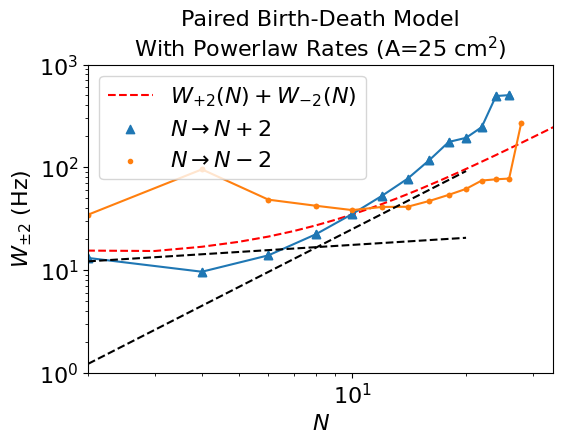

In [109]:
# nobsp_values
# nobsm_values
# Np_values
# Nm_values
fontsize = 16
#plot 1-diagonal of the transition matrix
Wsumv=(1-np.diag(jump_likelihood_matrix))/DT #Hz
Nv=np.arange(Wsumv.shape[0])

fig,ax=plt.subplots(figsize=(6,4))
plt.plot(Nv,Wsumv,'r--',label='$W_{+2}(N)+W_{-2}(N)$')
#plot the simulation results
plt.plot(Np_values,Wp_values,color='C0',marker='^')#,label=r'$N\rightarrow N+2$')
plt.plot(Nm_values,Wm_values,color='C1',marker='.')#,label=r'$N\rightarrow N-2$')
plt.scatter(Np_values,Wp_values,color='C0',marker='^',label=r'$N\rightarrow N+2$')
plt.scatter(Nm_values,Wm_values,color='C1',marker='.',label=r'$N\rightarrow N-2$')
plt.legend(fontsize=fontsize)
format_plot(fontsize=fontsize,xlabel=r'$N$',ylabel=r'$W_{\pm2}$ (Hz)')
plt.xscale('log')
plt.yscale('log')

xv = np.linspace(2,20,101)
plt.plot(xv,Mp*A*(xv/A)**nup,'k--')
plt.plot(xv,Mm*A*(xv/A)**num,'k--')

plt.xlim([2,34])
plt.ylim([1,1e3])

plt.title(f'Paired Birth-Death Model\nWith Powerlaw Rates ({A=} cm'+r'$^2$)',fontsize=fontsize)

plt.show()

In [74]:
DT
#DONE: see if ^that gives the right rates
#DONE: change it to check only once per 1ms, like before
#HINT: just change DT to 1e-3 seconds...  looks wrong kinda like the same way as the LPM's bdrates

#ROOT CAUSE IDENTIFIED?  DOES DECREASING DT FIX THE PROBLEM???

1e-07

In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# scratchwerk

In [ ]:
max_num_particles_init_over_2=200
# DT=0.000025 #stable
t_matrix = construct_transition_matrix_paired_bd_process(Wp,Wm,
                                max_num_particles_init_over_2=max_num_particles_init_over_2)#,**kwargs)
t_matrix*=DT #transfer func is now in dimensionless units 

In [ ]:
# num_iter=int(Nmax/2)
dim=max_num_particles_init_over_2
N_qs,P_qs = comp_quasistatic_distrib_paired_bdrates(Wm,Wp,num_iter=dim,freq_prev=1.)
# P_qs/=np.sum(P_qs) #normalize for 1.0000000000000002 floating point arith error
# assert np.sum(P_qs)==1
P_qs.shape,np.sum(P_qs)

# simulate particle number time series for repeated discrete simulations

In [ ]:
# np.cumsum(t_matrix[:198,:198],axis=1)[-1]
t_matrixb = t_matrix.copy()
imax = t_matrixb.shape[0]
t_matrixb[-1,-2] = Wp(2*imax-2)*DT
t_matrixb[-2,-1] = Wm(2*imax)*DT
#reflecting bc
t_matrixb[-1,-1] = -t_matrixb[-2,-1]
#absorbing bc
t_matrixb[:,0] *= 0.
# t_matrixb[0,:] *= 0.
# np.cumsum(t_matrixb,axis=1)[-1]
# t_matrixb.max()#[:,-1]
t_matrixb

In [ ]:
np.eye(t_matrix.shape[0])+np.cumsum(t_matrix,axis=0)#[:,-1]
np.cumsum(t_matrix,axis=0)[:,-1]
np.around(np.cumsum(t_matrix,axis=0)[-2],5)
np.around(np.cumsum(t_matrix,axis=0)[-1],5)
np.around(np.cumsum(t_matrix,axis=0)[0],5)
sum(np.around(t_matrix[0],5))
t_matrix[0]
# sum(t_matrix[50])
# sum(np.around(t_matrix[-1],5))
# sum(np.around(t_matrix[-2],5))

# simulate termination times in the continuum

In [ ]:
#<10s run time to simulate
#num_steps=100000
# tmax=25
tmax=100
num_steps=int(tmax/DT)
P_values=P_qs.copy()
print(f"{sum(P_values)=}")
t_values,P_net_values = integrate_transition_matrix(t_matrix,P_values,
                                num_steps=num_steps,save_every=1000)#,**kwargs)
print(f"{P_net_values[-1]=}")

In [ ]:
fig,ax=plt.subplots(figsize=(6,4))
ax.plot(t_values,P_net_values,lw=1,color='k')
# ax.plot(t_values,P_net_values,lw=1)
# ax.set_xlim([DT/2,1.1])
# ax.set_ylim([0.001,1])
# ax.set_xscale('log')
ax.set_yscale('log')
format_plot(ax=ax,xlabel='time (s)',ylabel='fraction not terminated',fontsize=14)
ax.tick_params(top=True, right=True,direction='in',which='both')
plt.ylim([1e-1,2])
plt.show()

In [ ]:
#compute the mean term. time from the OLS fit
x,y=t_values,P_net_values
B,Delta_B,m,Delta_m,Rsq=fit_exponential(x,y)
rmse=compute_exponential_rmse(x,y,m,B)
print_fit_exponential(x,y)
mte = -1/m
Delta_mte = Delta_m/(m**2)

In [ ]:
#evaluate Eqn. 10
num_iter=20
# num_iter=40
num_iter=80
# A=25
num_iter
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
phi = get_phi(comp_Wm,comp_Wp)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.) #correct qs
Nbar = np.dot(n_qs,prob_qs)
eval_tau= get_eval_tau(eval_tau_expression)
tau = eval_tau(n_qs, prob_qs, phi, comp_Wm, comp_Wp, printing=False,**kwargs)
# print(f"tau: {tau:f} (eqn. 10)")
print(f"tau: {tau:e} (eqn. 10)")
print(f"mte: {mte:f} ± {Delta_mte:f} seconds (transition matrix)")
print(f"mean num particles: {Nbar} (powerlaw)")